In [8]:
%matplotlib inline

import sys
sys.executable
print(sys.executable)
print(sys.version)
print(sys.version_info)

from __future__ import division

import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
from scipy.integrate import odeint
from scipy.special import erf
from scipy.integrate import quad, dblquad
from scipy.interpolate import interp1d,interp2d,RectBivariateSpline, griddata

import emcee

#----- MATPLOTLIB paramaters ---------
mpl.rcParams.update({'font.size': 18,'font.family':'sans-serif'})

mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
#--------------------------------------

/Library/Frameworks/Python.framework/Versions/3.5/bin/python3
3.5.0 (v3.5.0:374f501f4567, Sep 12 2015, 11:00:19) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
sys.version_info(major=3, minor=5, micro=0, releaselevel='final', serial=0)


In [14]:
G_N = 4.302e-3 #(pc/solar mass) (km/s)^2
G_N_Mpc = 1e-6*4.302e-3 #(Mpc/solar mass) (km/s)^2

h = 0.678
Omega_DM = 0.1186/(h**2)
H0 = 100.0*h #(km/s) Mpc^-1
H0_peryr = 67.8*(3.24e-20)*(60*60*24*365)
ageUniverse = 13.799e9 #y
Omega_L = 0.692
Omega_m = 0.308
Omega_r = 9.3e-5

z_eq = 3375.0
rho_eq = 1512.0 #Solar masses per pc^3
sigma_eq = 0.005 #Variance of DM density perturbations at equality
lambda_max = 3.0

alpha = 0.1

rtr_interp = None
Ubind_interp = None
current_MPBH = -10.0

In [15]:
#Several useful functions that provide truncation radius, mass of accreted DM halo, decoupling redshift

#M_PBH in solar masses

def r_trunc(z, M_PBH):
    r0 = 6.3e-3 #1300 AU in pc
    return r0*(M_PBH)**(1.0/3.0)*(1.+z_eq)/(1.+z)

#Truncation radiation at equality
def r_eq(M_PBH):
    return r_trunc(z_eq, M_PBH)

#DM Halo mass
def M_halo(z, M_PBH):
    return M_PBH*(r_trunc(z, M_PBH)/r_eq(M_PBH))**1.5

def xbar(f, M_PBH):
    return (3.0*M_PBH/(4*np.pi*rho_eq*(0.85*f)))**(1.0/3.0)

def semimajoraxis(z_pair, f, M_PBH):
    Mtot = M_PBH
    X = 3.0*z_eq*0.85*f/z_pair
    return alpha*xbar(f, M_PBH)*(f*0.85)**(1.0/3.0)*((X/(0.85*f))**(4.0/3.0))

def semimajoraxis_full(z_pair, f, M_PBH):
    Mtot = M_PBH + M_halo(z_pair, M_PBH)
    X = 3.0*z_eq*0.85*f/z_pair
    return alpha*xbar(f, Mtot)*(f*0.85)**(1.0/3.0)*((X/(0.85*f))**(4.0/3.0))

def bigX(x, f, M_PBH):
    return (x/(xbar(f,M_PBH)))**3.0

def x_of_a(a, f, M_PBH, withHalo = False):
    
    xb = xbar(f, M_PBH)
    
    if (not withHalo):        
        return ((a * (0.85*f) * xb**3)/alpha)**(1.0/4.0)
    
    elif (withHalo):                                                              
        xb_rescaled = xb * ((M_PBH + M_halo(a, M_PBH))/M_PBH )**(1./3.)            
        return ((a * (0.85*f) * xb_rescaled**3)/alpha)**(1.0/4.0)

def a_of_x(x, f, M_PBH):
    
    xb = xbar(f, M_PBH)
    return (alpha/(0.85*f))*x**4/xb**3    
    
#Maximum semi-major axis
def a_max(f, M_PBH, withHalo = False):
    Mtot = 1.0*M_PBH
    if (withHalo):
        Mtot += M_halo(z_eq, M_PBH)
    return alpha*xbar(f, Mtot)*(f*0.85)**(1.0/3.0)*((lambda_max)**(4.0/3.0))
    
def z_decoupling(a, f, mass):
    return (1. + z_eq)/(1./3 * bigX(x_of_a(a, f, mass), f, mass)/(0.85*f)) - 1.

def GetRtrInterp(M_PBH):
    
    global rtr_interp
    
    am = a_max(0.01, M_PBH, withHalo=True)
    a_list = np.logspace(-8, np.log10(am*1.1), 101)

    z_decoupling_0 = z_decoupling(a_list, 0.01, M_PBH)
    M_halo_0 = M_halo(z_decoupling_0, M_PBH)

    z_decoupling_1 = np.zeros(len(a_list))
    M_halo_1 = np.zeros(len(a_list))
    for i in range(len(a_list)):
        z_decoupling_1[i] = z_decoupling(a_list[i], 0.01, (M_halo_0[i]+M_PBH))
        M_halo_1 = M_halo(z_decoupling_1, (M_PBH))

    z_decoupling_2 = np.zeros(len(a_list))
    M_halo_2 = np.zeros(len(a_list))
    for i in range(len(a_list)):
        z_decoupling_2[i] = z_decoupling(a_list[i], 0.01, (M_halo_1[i]+M_PBH))
        M_halo_2 = M_halo(z_decoupling_2, (M_PBH))

    z_decoupling_3 = np.zeros(len(a_list))
    z_decoupling_check = np.zeros(len(a_list))
    M_halo_3 = np.zeros(len(a_list))
    for i in range(len(a_list)):
        z_decoupling_3[i] = z_decoupling(a_list[i], 0.01, (M_halo_2[i]+M_PBH))
        M_halo_3 = M_halo(z_decoupling_3, (M_PBH))
        #
        z_decoupling_check[i] = (1. + z_eq) / (1./3 * bigX(x_of_a(a_list[i], 0.01, (M_halo_3[i]+M_PBH)), 0.01, (M_halo_3[i]+M_PBH))/(0.85*0.01)) - 1.
        #
    
    r_list = r_trunc(z_decoupling_3, M_PBH)
    rtr_interp = interp1d(a_list, r_list)
    return rtr_interp


def CalcTruncRadius(ai, M_PBH):
    
    z_decoupling_0 = z_decoupling(ai, 0.01, M_PBH)
    M_halo_0 = M_halo(z_decoupling_0, M_PBH)

    z_decoupling_1 = z_decoupling(ai, 0.01, (M_halo_0+M_PBH))
    M_halo_1 = M_halo(z_decoupling_1, (M_PBH))

    z_decoupling_2 = z_decoupling(ai, 0.01, (M_halo_1+M_PBH))
    M_halo_2 = M_halo(z_decoupling_2, (M_PBH))

    z_decoupling_3 = z_decoupling(ai, 0.01, (M_halo_2+M_PBH))
    M_halo_3 = M_halo(z_decoupling_3, (M_PBH))

    r_list = r_trunc(z_decoupling_3, M_PBH)
    return r_list

In [16]:
# Some useful cosmological functions

def Hubble(z):
    return H0_peryr*np.sqrt(Omega_L + Omega_m*(1+z)**3 + Omega_r*(1+z)**4)

def Hubble2(z):
    return H0*np.sqrt(Omega_L + Omega_m*(1+z)**3 + Omega_r*(1+z)**4)

def HubbleLaw(age):
    return H0_peryr*age

def rho_z(z):
    return 3.0*Hubble2(z)**2/(8*np.pi*G_N)

def t_univ(z):
    integ = lambda x: 1.0/((1+x)*Hubble(x))
    return quad(integ, z, np.inf)[0]

def Omega_PBH(f):  
    return f*Omega_DM

rho = 3.0*H0**2/(8.0*np.pi*G_N_Mpc) #Solar masses per Mpc^3

def n_PBH(f, M_PBH): 
    return (1e3)**3*rho*Omega_PBH(f)/M_PBH #PBH per Gpc^3

In [17]:
#Probability distributions

def j_X(x, f, M_PBH):
    return bigX(x, f, M_PBH)*0.5*(1+sigma_eq**2/(0.85*f)**2)**0.5

def P_j(j, x, f, M_PBH):
    y = j/j_X(x, f, M_PBH)
    return (y**2/(1+y**2)**(3.0/2.0))/j

def P_a_j(a, j, f, M_PBH):
    
    xval = x_of_a(a, f, M_PBH)
    X = bigX(xval, f, M_PBH)
    xb = xbar(f, M_PBH)
    measure = (3.0/4.0)*(a**-0.25)*(0.85*f/(alpha*xb))**0.75
    return P_j(j, xval, f, M_PBH)*np.exp(-X)*measure

def P_a_j_withHalo(a, j, f, M_PBH):
    
    xval = x_of_a(a, f, M_PBH, withHalo = True)
    X = bigX(xval, f, M_PBH)
    xb = xbar(f, M_PBH)
    
    measure = (3.0/4.0)*(a**-0.25)*(0.85*f/(alpha*xb))**0.75    
    measure *= ((M_PBH + M_halo(a, M_PBH))/M_PBH )**(3./4.)
    
    return P_j(j, xval, f, M_PBH)*np.exp(-X)*measure

def j_of(z,a, M_PBH):
    Q = (3.0/170.0)*(G_N*M_PBH)**-3
    return (  (-(z/H0_peryr) + ageUniverse)/(Q*a**4.) )**(1./7.)

def a_max(f, M_PBH):
    return alpha*xbar(f, M_PBH)*(f*0.85)**(1.0/3.0)*((lambda_max)**(4.0/3.0))

def a_max_with_Halo(f, M_PBH):
    return alpha*xbar(f, 2.*M_PBH)*(f*0.85)**(1.0/3.0)*((lambda_max)**(4.0/3.0))

def P_la_lj(la,lj, f, M_PBH):
    j = 10.**lj
    a = 10.**la
    return P_a_j(a, j, f, M_PBH)*a*j*(np.log(10)**2) #/Norm1

def P_la_lj_withHalo(la, lj, f, M_PBH):
    j = 10**lj
    a = 10**la
    return P_a_j_withHalo(a, j, f, M_PBH)*a*j*(np.log(10)**2) #/Norm2

def t_coal(a, e, M_PBH):
    Q = (3.0/170.0)*(G_N*M_PBH)**(-3) # s^6 pc^-3 km^-6
    tc = Q*a**4*(1-e**2)**(7.0/2.0) #s^6 pc km^-6
    tc *= 3.086e+13 #s^6 km^-5
    tc *= (3e5)**5 #s
    return tc/(60*60*24*365) #in years

def j_coal(a, t, M_PBH):
    Q = (3.0/170.0)*(G_N*M_PBH)**-3 # s^6 pc^-3 km^-6
    tc = t*(60*60*24*365)
    tc /= (3e5)**5
    tc /= 3.086e+13
    return (tc/(Q*a**4))**(1.0/7.0)

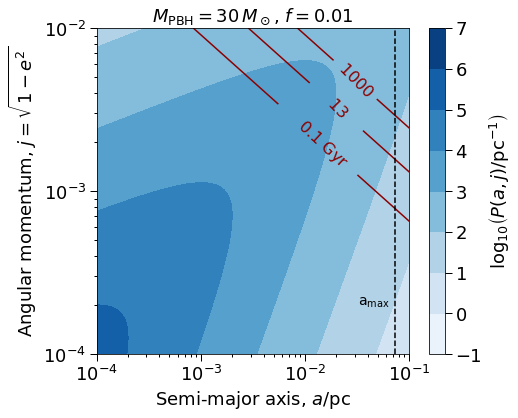

In [22]:
# PDF plot for M_PBH = 30Msun and f_PHB = 0.01

M_PBH_ref = 30.
f_ref  = 0.01

amin = 5.e-5
amax = a_max(f_ref, M_PBH_ref)

P1 = lambda y,x,f,M_PBH: P_a_j(x, y, f, M_PBH)
Norm1 =  dblquad(P1, amin, amax, lambda x: 0,  lambda x: 1, args=(f_ref, M_PBH_ref), epsrel=1e-20)[0]

a_list = np.logspace(-5, np.log10(amax*1.5), 501)
j_list = np.logspace(-5, -2, 501)

a_grid, j_grid = np.meshgrid(a_list, j_list, indexing='xy')
e_grid = np.sqrt(1-j_grid**2)

P_a_j_vec = np.vectorize(P_a_j, excluded=(2,3))

pl.figure(figsize=(7,6))

cf = pl.contourf(a_grid,j_grid, np.log10(P_a_j_vec(a_grid, j_grid, f_ref, M_PBH_ref)/Norm1), cmap="Blues")
pl.colorbar(cf,label=r"$\log_{10}\left(P(a, j)/\mathrm{pc}^{-1} \right)$")

CS = pl.contour(a_grid, j_grid, t_coal(a_grid, e_grid, M_PBH_ref)/(1e9), levels=[0.1,13.0,1000.0],colors='DarkRed' )

pl.clabel(CS, levels=[13.0],  # label every second level
           inline=1,
           fmt='    %1.f    ',
           fontsize=16,
            manual=([0.018, 0.003],))

pl.clabel(CS, levels=[1000.],  # label every second level
           inline=1,
           fmt='    %1.f    ',
           fontsize=16,
            manual=([0.045, 0.006],))

pl.clabel(CS, levels=[0.1],  # label every second level
           inline=1,
           #fmt='$t_\\mathrm{merge}$=%1.1f Gyr$\,$ ',
           fmt='    %1.1f Gyr$\,$    ',
           fontsize=16,
            manual=([0.005, 0.001],))

pl.xlabel("Semi-major axis, $a/\mathrm{pc}$")
pl.ylabel("Angular momentum, $j = \sqrt{1-e^2}$")
pl.title(r"$M_\mathrm{PBH} = " + str(int(M_PBH_ref)) + "\,M_\odot$, $f = " + str(f_ref) + "$",fontsize=18)

pl.axvline(a_max(0.01, 30.), linestyle='--', color='k')

pl.xlim(1.e-4, 0.1)
pl.ylim(1.e-4, 0.01)
pl.xscale("log")
pl.yscale("log")

pl.text(0.032, 0.0002,r"a$_{\rm max}$",color='black',fontsize=14.0)

pl.savefig("PDF.pdf",bbox_inches="tight")

pl.show()

In [6]:
# REMAPPING PRESCRIPTION

def energy_released(a, M_PBH):
    
        rtr_interp = GetRtrInterp(M_PBH)    
        r_cut = rtr_interp(a)
        r1 = 1.e-8
        r2 = r_cut
        integrand = lambda x: density(x, M_PBH)*x*(Menc(x, M_PBH))
        return 4. * np.pi * G_N * quad(integrand, r1, r2)[0]   # in Msun km^2/s^2

def orbital_energy(a, M_total):
    
    return -G_N*M_total**2./(2.*a) #Msun * (km/s)^2

def a_as_function_of_energy(E, M_PBH):
    
    return -G_N*M_PBH**2./(2.*E)

def a_final(a, M_PBH):
    
    return a_as_function_of_energy( orbital_energy(a, M_PBH+M_halo(a, M_PBH))-2.*energy_released(a, M_PBH), M_PBH)
        
def j_final(a, e, M_PBH):
    
    j = np.sqrt(1.-e*e)
    # a j^2 = a_f2 j_f^2.
    return np.sqrt(a* (j**2.) / a_final(a, M_PBH)) 


a_list = np.logspace(np.log10(1e-4), np.log10(1e-1), 11)
j_list = np.logspace(np.log10(1e-4), np.log10(1e-1), 11)
e_list = np.sqrt(1-j_list**2)

print(a_list)
print(j_list)

a_final_list         = np.zeros(len(a_list))
energy_released_list = np.zeros(len(a_list))
orbital_energy_list  = np.zeros(len(a_list))
#                            
j_final_list = np.zeros((len(a_list), len(e_list)))

for ia in range(len(a_list)):
    a_final_list[ia] = a_final(a_list[ia], M_PBH_ref)
    energy_released_list[ia] = energy_released(a_list[ia], M_PBH_ref)
    orbital_energy_list[ia]   = orbital_energy(a_list[ia], M_PBH_ref)                                    
    for ie in range(len(e_list)):
        j_final_list[ia,ie] = j_final(a_list[ia], e_list[ie], M_PBH_ref) 

for ind in range(len(a_list)):
    print("a = ", a_list[ind], "; a_final = ", a_final_list[ind])
    
def a_initial(a_final):
    
    return 0.

def t_final(t_initial, a_initial):
    
    return 0.

def t_initial(t_final, a_final):
    
    return 0.

[ 0.0001      0.00019953  0.00039811  0.00079433  0.00158489  0.00316228
  0.00630957  0.01258925  0.02511886  0.05011872  0.1       ]
[ 0.0001      0.00019953  0.00039811  0.00079433  0.00158489  0.00316228
  0.00630957  0.01258925  0.02511886  0.05011872  0.1       ]
a =  0.0001 ; a_final =  9.93705437266e-05
a =  0.000199526231497 ; a_final =  0.000196401666769
a =  0.000398107170553 ; a_final =  0.00038275428193
a =  0.000794328234724 ; a_final =  0.00072113165562
a =  0.00158489319246 ; a_final =  0.00126009766292
a =  0.00316227766017 ; a_final =  0.00190846608873
a =  0.0063095734448 ; a_final =  0.00235234102473
a =  0.0125892541179 ; a_final =  0.00235868069884
a =  0.0251188643151 ; a_final =  0.00203955498912
a =  0.0501187233627 ; a_final =  0.00160907412098
a =  0.1 ; a_final =  0.00123725994882


In [7]:
sens_data_10Msun = np.loadtxt("LIGO_sensitivity_10.txt")
sens_data_20Msun = np.loadtxt("LIGO_sensitivity_20.txt")
sens_data_40Msun = np.loadtxt("LIGO_sensitivity_40.txt")

sens_10Msun = interp1d(sens_data_10Msun[:,0], sens_data_10Msun[:,1], bounds_error=False, fill_value=0.0)
sens_20Msun = interp1d(sens_data_20Msun[:,0], sens_data_20Msun[:,1], bounds_error=False, fill_value=0.0)
sens_40Msun = interp1d(sens_data_40Msun[:,0], sens_data_40Msun[:,1], bounds_error=False, fill_value=0.0)

N_20_flat = quad(sens_20Msun, 0, 0.7)[0]
N_40_flat = quad(sens_40Msun, 0, 0.7)[0]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


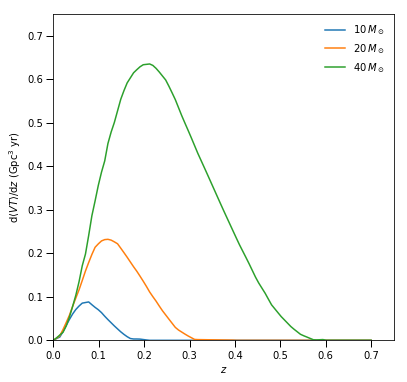

In [8]:
zvals = np.linspace(0, 0.7, 100)

sensitivities = [sens_10Msun, sens_20Msun, sens_40Msun]
labels = [r"$10\,M_\odot$",r"$20\,M_\odot$",r"$40\,M_\odot$"]

pl.figure(figsize=(6.1,6))

for sens, lab in zip(sensitivities, labels):
    pl.plot(zvals, sens(zvals), linewidth=1.5, label=lab)
    
pl.xlim(0,0.75)
pl.ylim(0, 0.75)
    
pl.xlabel(r"$z$")
pl.ylabel(r"$\mathrm{d}\langle V T \rangle/\mathrm{d}z$ (Gpc$^3$ yr)")

pl.legend(loc='upper right', frameon=False)

pl.show()

In [9]:
tmin_sampling = 1.e8
tmax_sampling = 1.e11

def lnprior(theta, f, M_PBH, a1, a2):    
    
    la, lj = theta
    a = 10**la
    j = 10**lj
    if (a < a1 or a > a2):
        return -np.inf
    t = t_coal(a, np.sqrt(1-j**2), M_PBH)
    if (t < tmin_sampling or t > tmax_sampling):
        return -np.inf
    else:
        return 0

def lnprob(theta, f, M_PBH, PDF, a1, a2):
    
    lp = lnprior(theta, f, M_PBH, a1, a2)
    if not np.isfinite(lp):
        return -np.inf
    
    la, lj = theta
    
    return lp + np.log(P_la_lj_withHalo(la, lj, f, M_PBH))
    
def GetSamples_MCMC(N_samps, PDF, a1, a2, f, M_PBH):
    
    ndim, nwalkers = 2, 10
    
    a0 = 0.5*(a1+a2)
    j0 = j_coal(a0, 13e9, M_PBH)
    #j0 = 1e-4
    p0 = [[np.log10(a0), np.log10(j0)] + 0.1*np.random.rand(ndim) for i in range(nwalkers)]
    #print p0
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[f, M_PBH, PDF, a1, a2])
    #sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
    sampler.run_mcmc(p0, N_samps)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
    return samples

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/emcee-3.0.0.dev0-py3.5.egg/emcee/moves/red_blue.py:96: RuntimeWarning: invalid value encountered in double_scalars


(99000, 2)
(99000,)
(99000,)
a =  0.0268674840602 ; j =  0.00232487072748 ; e =   0.999997297484 ; remapped a =  0.00199974876012 ; remapped j =   0.00852166762457 ; remapped e =  0.999963689931
t =  3734157262.7 ; t_remapped =  1018748124.7
a =  0.0236998185859 ; j =  0.00378634769149 ; e =   0.99999283176 ; remapped a =  0.00207321472884 ; remapped j =   0.0128017947453 ; remapped e =  0.999918053668
t =  68709449338.3 ; t_remapped =  20321983757.9
100242832.372
99733510720.3


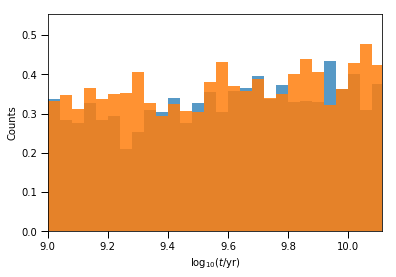

In [10]:
#Compute the rate from sampled and remapped Kamionkowski distribution 

Nsamples = 10000

#
samples_MCMC = GetSamples_MCMC(Nsamples, P_la_lj, amin, amax, f_ref, M_PBH_ref)
#

print(samples_MCMC.shape)
la_vals_all = samples_MCMC[:,0]
lj_vals_all = samples_MCMC[:,1]
print(la_vals_all.shape)
print(lj_vals_all.shape)
z_vals_all = np.zeros(Nsamples)
t_vals_all = np.zeros(Nsamples)
z_vals_remapped = np.zeros(Nsamples)
t_vals_remapped = np.zeros(Nsamples)

counter = 0
for ind in range(Nsamples):    
    a_ = 10.**(la_vals_all[ind])
    j_ = 10.**(lj_vals_all[ind])
    e_ = np.sqrt(1. -  (j_**2.))
    current_t_coal = t_coal(a_, e_, M_PBH_ref) 
    current_z = H0_peryr * (ageUniverse - current_t_coal)
    if ((current_z < 0.) or (current_z > 0.99)):
        current_z = 1.
        counter += 1
    #else:
    #    print(current_z)
    t_vals_all[ind] = current_t_coal        
    z_vals_all[ind] = current_z
    #
    #
    #
    remapped_a = a_final(a_, M_PBH_ref)
    remapped_j = j_final(a_, e_, M_PBH_ref)
    remapped_e = np.sqrt(1. -  (remapped_j**2.))
    remapped_t_coal = t_coal(remapped_a, remapped_e, M_PBH_ref) 
    remapped_z = H0_peryr * (ageUniverse - remapped_t_coal)
    z_vals_remapped[ind] = remapped_z
    t_vals_remapped[ind] = remapped_t_coal
    if (ind%5000==0):
        print("a = ", a_, "; j = ", j_, "; e =  ", e_, "; remapped a = ", remapped_a, "; remapped j =  ", remapped_j, "; remapped e = ", remapped_e)
        print("t = ", current_t_coal, "; t_remapped = ", remapped_t_coal)

print(np.min(t_vals_all))
print(np.max(t_vals_all))

#pl.figure()
#nz, bins_z, patches = pl.hist(z_vals_all, range=(0.,1.), density=True, bins=100)
#pl.xlim(0.,0.9)
#pl.show() 
#
#pl.figure()
#nz_remapped, bins_z_remapped, patches = pl.hist(z_vals_remapped, range=(0.,1.), density=True, bins=100)
#pl.xlim(0.,0.9)
#pl.show() 

bins_t = np.logspace(7, 11, 101)
logBins_t = np.linspace(7, 11, 101)
bins_t_centres = np.sqrt(bins_t[:-1]*bins_t[1:])
    
pl.figure()
nt, bins_t, patches = pl.hist(np.log10(t_vals_all), bins=logBins_t, normed=True, alpha=0.75)
#pl.show()    
#
#pl.figure()
nt_remapped, bins_t_remapped, patches = pl.hist(np.log10(t_vals_remapped), bins=logBins_t, normed=True, alpha=0.85)
#pl.show()    
pl.xlim(9, np.log10(13e9))
pl.xlabel(r'$\log_{10}(t/\mathrm{yr})$')
pl.ylabel('Counts')
pl.show()


#bins_t_centers = np.zeros(len(nt))
#indMax = len(bins_t_centers)
#print("original histogram")
#for ind in range(indMax):
#    bins_t_centers[ind] = 0.5*(bins_t[ind] + bins_t[ind+1])
#    print(bins_t_centers[ind]/1.e9, " ", nt[ind])
#P_of_t = interp1d(bins_t_centers, nt)
#

#t_vec = np.logspace(np.log10(bins_t_centers[0]+1.), np.log10(bins_t_centers[indMax-1]-1.), num = 20)
#print(t_vec/1.e9)
#P_of_t_vec = P_of_t(t_vec)

#bins_t_centers_remapped = np.zeros(len(nt_remapped))
#indMax = len(bins_t_centers_remapped)
#print("remapped histogram")
#for ind in range(indMax):
#    bins_t_centers_remapped[ind] = 0.5*(bins_t_remapped[ind] + bins_t_remapped[ind+1])
#    print(bins_t_centers_remapped[ind]/1.e9, " ", nt_remapped[ind])
#P_of_t_remapped = interp1d(bins_t_centers_remapped, nt_remapped)
#

#t_vec_remapped = np.logspace(np.log10(bins_t_centers_remapped[0]+1.), np.log10(bins_t_centers_remapped[indMax-1]-1.), num = 20)
#P_of_t_vec_remapped = P_of_t_remapped(t_vec_remapped)

#pl.xlabel("t_coal [y] ")
#pl.ylabel("P(t) normalized")
#pl.loglog(t_vec, P_of_t_vec)

#pl.xlabel("t_coal [y] ")
#pl.ylabel("P(t) remapped normalized")
#pl.loglog(t_vec, P_of_t_vec_remapped)

#P_norm = np.trapz(P_of_t_vec, t_vec)
#print("normalization = ",P_norm)

In [10]:
#Compute the rate from sampled and remapped Kamionkowski distribution - Analytical

def P_t_integ(a, t, f, M_PBH, withHalo):
        
    c = 3.e5 #km/s
    Q = (c**6)*(3.0/170.0)*(G_N*M_PBH)**-3 # pc^-3
    t_pc = t*(60*60*24*365)*c*3.24078e-14 #Time in years -> Time in parsec    
    ecc = np.sqrt(1-(t_pc*1.0/(Q*a**4))**(2.0/7.0))
    j_ecc = np.sqrt(1. - ecc**2.)
    #print("eccentricity = ", ecc, "; j = ", j_ecc)
    #print a, ecc
    
    #######################################
    
    P1 = 1.

    #P1 = Sasaki.P_ae(a, ecc, f, M_PBH)
    if (withHalo == False):
        P1 = P_a_j(a, j_ecc, f, M_PBH)
    else:
        P1 = P_a_j_withHalo(a, j_ecc, f, M_PBH)

    #######################################
    
    #print("P1 = ", P1)   
    djdt = j_ecc/(7*t)
    #print("dzde = ", dzde)
    #dzdj = 7 * H0_peryr * t / j_ecc 
    return P1*djdt

#Time in years
def P_t_of_z_analytical(z, f, M_PBH, withHalo):
    
    #print("*** z = ", z)
    
    t = t_univ(z)
        
    avals = np.logspace(np.log10(amin), np.log10(amax), 101) #pc
    test = np.asarray([P_t_integ(a, t, f, M_PBH, withHalo) for a in avals])
    
    #for ind in range(len(avals)):
    #    print(avals[ind], " ", test[ind])
        
    integr = np.trapz(test, avals, withHalo)
    #print("integral", integr) #this should have dimension of time
    #print("sensitivity = ", sens_20Msun(z)) #Gpc^3 yr^-1
    #print("n_PBH = ", n_PBH) #Gpc^(-3)
    #print("H0_peryr = ", H0_peryr)
    
    #return quad(P_t_integ, 0.0, 10.0,args=(t, f, M_PBH))[0]
    return integr

def P_of_t_analytical(t, f, M_PBH, withHalo):
    
        
    avals = np.logspace(np.log10(amin), np.log10(amax), 101) #pc
    test = np.asarray([P_t_integ(a, t, f, M_PBH, withHalo) for a in avals])
    
    #for ind in range(len(avals)):
    #    print(avals[ind], " ", test[ind])
        
    integr = np.trapz(test, avals)
    #print("integral", integr) #this should have dimension of time
    #print("sensitivity = ", sens_20Msun(z)) #Gpc^3 yr^-1
    #print("n_PBH = ", n_PBH) #Gpc^(-3)
    #print("H0_peryr = ", H0_peryr)
    
    #return quad(P_t_integ, 0.0, 10.0,args=(t, f, M_PBH))[0]
    return integr

def P_of_t_analytical_Bradley(t, f, M_PBH, withHalo):
    
    if (withHalo):
        amax = a_max(f, 2.0*M_PBH)
    else:
        amax = a_max(f, M_PBH)

    alist = np.logspace(np.log10(amin), np.log10(amax), 100)
    Plist = 0.0*alist
    
    for i, a in enumerate(alist):
        
        j = j_coal(a, t, M_PBH)
        if (j >= 1):
            Plist[i] = 0
            
        else:
            e = np.sqrt(1-j**2)
            djde = e/j
            dedt = (j**2/e)/(7.0*t)
            
            if (withHalo):
                Plist[i] = P_a_j_withHalo(a, j, f, M_PBH)*djde*dedt
            else:
                Plist[i] = P_a_j(a, j, f, M_PBH)*djde*dedt
        
    return np.trapz(Plist, alist)

###########################################################################

#print("N_PBH [Gpc^-3] = ", n_PBH)
#print("H0_peryr = ",H0_peryr)

#Integrate over sensitivity to get number of events
#We don't have the sensitivity curve for 30 Msun, so do 20 Msun and 40 Msun
integrand_20 = lambda x: n_PBH(f_ref, 30.)*sens_20Msun(x)*P_t_of_z_analytical(x, f_ref, 30., withHalo=False) # Gpc^(-3) * Gpc^3 yr * yr^(-1)
integrand_40 = lambda x: n_PBH(f_ref, 30.)*sens_40Msun(x)*P_t_of_z_analytical(x, f_ref, 30., withHalo=False)

#z_list = np.linspace(0., 0.7, num=10)
#merge_rate_list = np.asarray([merger_rate_z(x, wPDF) for x in z_list])
#for i in range(len(z_list)):
#    print(z_list[i], " ", merge_rate_list[i])

#Number of merger events above a given threshold in the search presented in 
N_20 = quad(integrand_20, 0, 0.7)[0]
N_40 = quad(integrand_40, 0, 0.7)[0]

print("Number of events above threshold:", N_20, "-", N_40)

N_20_flat = quad(sens_20Msun, 0, 0.7)[0]
N_40_flat = quad(sens_40Msun, 0, 0.7)[0]

print("Inferred Merger Rate [Gpc^-3 yr^-1]:", N_20/N_20_flat," - ",N_40/N_40_flat)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Number of events above threshold: 15.639850881539001 - 83.46996377066432
Inferred Merger Rate [Gpc^-3 yr^-1]: 430.3087947286031  -  473.193173055618


In [11]:
#def P_t_of_z_numerical(z_):
#    return P_of_t(t_univ(z_))

#def P_t_of_z_numerical_remapped(z_):
#    return P_of_t_remapped(t_univ(z_))

t_vec = np.logspace(np.log10(tmin_sampling), np.log10(tmax_sampling), 1000)

P_true = np.asarray([P_of_t_analytical(t_, f_ref, M_PBH_ref, withHalo=False) for t_ in t_vec])
P_true_withHalo = np.asarray([P_of_t_analytical(t_, f_ref, M_PBH_ref, withHalo=True) for t_ in t_vec])

int_analytical = np.trapz(P_true, t_vec)
int_analytical_withHalo = np.trapz(P_true_withHalo, t_vec)

nt_normalized = nt/(bins_t_centres*np.log(10))
nt_remapped_normalized = nt_remapped/(bins_t_centres*np.log(10))

P_t_numerical          = interp1d(bins_t_centres, nt_normalized, kind='linear')
P_t_remapped_numerical = interp1d(bins_t_centres, nt_remapped_normalized, kind='linear')

int_numeric = np.trapz(nt_normalized, bins_t_centres)
print("normalization of the histogram = ", int_numeric)

#int_analytical = quad(P_t_of_z_analytical, 0, 0.7, args=(f_ref, 30.))[0]
#int_numeric = quad(P_t_of_z_numerical, 0, 0.7)[0]
#int_numeric_remapped = quad(P_t_of_z_numerical_remapped, 0, 0.7)[0]

#Nb = len(bins_t_centers)

#int_analytical = quad(P_of_t_analytical, bins_t_centers[0], bins_t_centers[Nb-1], args=(f_ref, 30.))[0]
#int_analytical = quad(P_of_t_analytical, tmin_sampling, tmax_sampling, args=(f_ref, 30.))[0]
#int_numeric = np.trapz(nt, bins_t_centers) # quad(P_of_t, tmin_sampling, tmax_sampling)[0]
#int_numeric_remapped = np.trapz(nt_remapped, bins_t_centers_remapped) # quad(P_of_t_remapped, tmin_sampling, tmax_sampling)[0]

def my_integrand_20(z_, f, M_PBH):  
    P_ = P_t_numerical(t_univ(z_))*int_analytical/int_numeric
    return (n_PBH(f,M_PBH)*sens_20Msun(z_)*P_)  # Gpc^3 yr Gpc^-3 1/yr 

def my_integrand_40(z_, f, M_PBH):  
    P_ = P_t_numerical(t_univ(z_))*int_analytical/int_numeric
    return (n_PBH(f,M_PBH)*sens_40Msun(z_)*P_)  # Gpc^3 yr Gpc^-3 1/yr 

def my_integrand_20_remapped(z_, f, M_PBH):  
    P_ = P_t_remapped_numerical(t_univ(z_))*int_analytical/int_numeric
    return (n_PBH(f,M_PBH)*sens_20Msun(z_)*P_)  # Gpc^3 yr Gpc^-3 1/yr 

def my_integrand_40_remapped(z_, f, M_PBH):  
    P_ = P_t_remapped_numerical(t_univ(z_))*int_analytical/int_numeric
    return (n_PBH(f,M_PBH)*sens_40Msun(z_)*P_)  # Gpc^3 yr Gpc^-3 1/yr 


integral_20 = quad(my_integrand_20, 0, 0.7, args=(f_ref, 30.))[0]
integral_40 = quad(my_integrand_40, 0, 0.7, args=(f_ref, 30.))[0]
integral_20_remapped = quad(my_integrand_20_remapped, 0, 0.7, args=(f_ref, 30.))[0]
integral_40_remapped = quad(my_integrand_40_remapped, 0, 0.7, args=(f_ref, 30.))[0]

N_20_flat = quad(sens_20Msun, 0, 0.7)[0]
N_40_flat = quad(sens_40Msun, 0, 0.7)[0]


print("Inferred Merger Rate from sampled Kamionkowski distribution [Gpc^-3 yr^-1]:", integral_20/N_20_flat," - ", integral_40/N_40_flat)
print("Inferred Merger Rate from REMAPPED Kamionkowski distribution [Gpc^-3 yr^-1]:", integral_20_remapped/N_20_flat," - ", integral_40_remapped/N_40_flat)
print("Relative change = ", np.abs(integral_20/N_20_flat -  integral_40/N_40_flat)/(integral_40/N_40_flat) )


NameError: name 'nt' is not defined

65536
[ 0.0001      0.00014678  0.00021544  0.00031623  0.00046416  0.00068129
  0.001       0.0014678   0.00215443  0.00316228  0.00464159  0.00681292
  0.01        0.01467799  0.02154435  0.03162278  0.04641589  0.06812921
  0.1       ]
z = 0.0, t =  13.80855996253245  Gyr
z = 0.1, t =  12.464655587717441  Gyr
z = 0.7, t =  7.318555103923487  Gyr
z = 1.0, t =  5.869771272473745  Gyr
z = 2.0, t =  3.28819843309768  Gyr
z = 7.0, t =  0.7631756819852304  Gyr
*** M =  10.0
*** f =  0.0001
Sampling PDF... 


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/emcee-3.0.0.dev0-py3.5.egg/emcee/moves/red_blue.py:96: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - log_probs[j]


...Done
fraction of binaries that merge today =  1.2844927228380465e-11 ; averaged =   2.1640249116203884e-11
0.0001	0.145031789422	0.265552073915

*** f =  0.000146779926762
Sampling PDF... 
...Done
fraction of binaries that merge today =  1.4933750810574348e-11 ; averaged =   2.2409042909481325e-11
0.000146779926762	0.312418806718	0.592354375704

*** f =  0.000215443469003
Sampling PDF... 
...Done
fraction of binaries that merge today =  1.5288355431286708e-11 ; averaged =   2.15807211748321e-11
0.000215443469003	0.672910661031	1.22868027235

*** f =  0.000316227766017
Sampling PDF... 
...Done
fraction of binaries that merge today =  1.5195115768851113e-11 ; averaged =   2.1800629124006332e-11
0.000316227766017	1.44900195751	2.67265617742

*** f =  0.000464158883361
Sampling PDF... 
...Done
fraction of binaries that merge today =  1.3133525103284059e-11 ; averaged =   2.1466059282047057e-11
0.000464158883361	3.11858266639	5.66362745309

*** f =  0.000681292069058
Sampling PDF... 
...

IndexError: index 1 is out of bounds for axis 0 with size 1

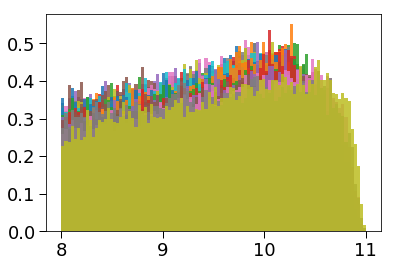

In [21]:
Nm = 3
Nf = 19
Nsamples = 2**16
print(Nsamples)
f_vec = np.logspace(-4.,-1., Nf)
m_vec = np.array([10., 30., 100.])
rate_vec = np.zeros((Nm,Nf))
rate_remapped_vec = np.zeros((Nm,Nf))
print(f_vec)

print("z = 0.0, t = ", t_univ(0.)/1.e9, " Gyr")
print("z = 0.1, t = ", t_univ(.1)/1.e9, " Gyr")
print("z = 0.7, t = ", t_univ(.7)/1.e9, " Gyr")
print("z = 1.0, t = ", t_univ(1.)/1.e9, " Gyr")
print("z = 2.0, t = ", t_univ(2.)/1.e9, " Gyr")
print("z = 7.0, t = ", t_univ(7.)/1.e9, " Gyr")

for i_m in range(Nm):
    
    print("*** M = ", m_vec[i_m])
    
    current_file = "rate_averaged_" + str(m_vec[i_m]) + ".txt"
    out_f = open(current_file, 'w')
    
    for i_f in range(Nf):    
        
        counter_today = 0
    
        print("*** f = ", f_vec[i_f])

        print("Sampling PDF... ")
        samples_MCMC = GetSamples_MCMC(Nsamples, P_la_lj_withHalo, amin, amax, f_vec[i_f], m_vec[i_m])
        print("...Done")

        la_vals_all = samples_MCMC[:,0]
        lj_vals_all = samples_MCMC[:,1]
        z_vals_all = np.zeros(Nsamples)
        t_vals_all = np.zeros(Nsamples)

        z_vals_remapped = np.zeros(Nsamples)
        t_vals_remapped = np.zeros(Nsamples)

        for ind in range(Nsamples):  
            
            a_ = 10.**(la_vals_all[ind])
            j_ = 10.**(lj_vals_all[ind])
            e_ = np.sqrt(1. -  (j_**2.))
            current_t_coal = t_coal(a_, e_, m_vec[i_m]) 
            current_z = H0_peryr * (ageUniverse - current_t_coal)
            if ((current_z < 0.) or (current_z > 0.99)):
                current_z = 1.
            t_vals_all[ind] = current_t_coal        
            z_vals_all[ind] = current_z
            remapped_a = a_final(a_, m_vec[i_m])
            remapped_j = j_final(a_, e_, m_vec[i_m])
            remapped_e = np.sqrt(1. -  (remapped_j**2.))
            remapped_t_coal = t_coal(remapped_a, remapped_e, m_vec[i_m]) 
            remapped_z = H0_peryr * (ageUniverse - remapped_t_coal)
            
            if ((remapped_z >= 0.) and (remapped_z <= 0.7)):
                counter_today += 1
            
            z_vals_remapped[ind] = remapped_z
            t_vals_remapped[ind] = remapped_t_coal

        bins_t = np.logspace(8, 11, 101)
        logBins_t = np.linspace(8, 11, 101)
        bins_t_centres = np.sqrt(bins_t[:-1]*bins_t[1:])
        
        #nt, bins_t, patches = pl.hist(np.log10(t_vals_all), bins=logBins_t, normed=True, alpha=0.75)
        nt_remapped, bins_t_remapped, patches = pl.hist(np.log10(t_vals_remapped), bins=logBins_t, normed=True, alpha=0.85)
        
        #nt_normalized = nt/(bins_t_centres*np.log(10))
        nt_remapped_normalized = nt_remapped/(bins_t_centres*np.log(10))
        
        #P_t_numerical          = interp1d(bins_t_centres, nt_normalized, kind='linear')
        P_t_remapped_numerical = interp1d(bins_t_centres, nt_remapped_normalized, kind='linear')
        
        #int_numeric = np.trapz(nt_normalized, bins_t_centres)

        t_vec = np.logspace(np.log10(tmin_sampling), np.log10(tmax_sampling), 1000)

        #P_true = np.asarray([P_of_t_analytical(t_, f_vec[i_f], m_vec[i_m], withHalo=False) for t_ in t_vec])
        P_true_withHalo = np.asarray([P_of_t_analytical(t_, f_vec[i_f], m_vec[i_m], withHalo=True) for t_ in t_vec])

        #int_analytical = np.trapz(P_true, t_vec)
        int_analytical_withHalo = np.trapz(P_true_withHalo, t_vec)

        #rate_vec[i_m, i_f] = n_PBH(f_vec[i_f],m_vec[i_m]) * P_t_numerical(t_univ(0.))*int_analytical_withHalo #/int_numeric
        rate_vec[i_m, i_f] = n_PBH(f_vec[i_f], m_vec[i_m]) * P_t_of_z_analytical(0., f_vec[i_f], m_vec[i_m], withHalo=False)

        my_integrand = lambda x: P_t_remapped_numerical(t_univ(x)) 
        my_integral = quad(my_integrand, 0.0, 0.9)[0] / 0.9  
        
        ##rate_remapped_vec[i_m, i_f] = n_PBH(f_vec[i_f],m_vec[i_m]) * P_t_remapped_numerical(t_univ(0.)) * int_analytical_withHalo #/int_numeric
        
        rate_remapped_vec[i_m, i_f] = n_PBH(f_vec[i_f],m_vec[i_m]) * my_integral * int_analytical_withHalo #/int_numeric 

        ##rate_remapped_vec[i_m, i_f] = n_PBH(f_vec[i_f],m_vec[i_m]) * (counter_today/(Nsamples*(t_univ(0.)-t_univ(.7)))) * int_analytical_withHalo #/int_numeric
   
        #print("M = ", m_vec[i_m],  "; f = ", f_vec[i_f], "; rate = ", rate_vec[i_m, i_f], "; rate remapped = ", rate_remapped_vec[i_m, i_f])    
        print("fraction of binaries that merge today = ", P_t_remapped_numerical(t_univ(0.)), "; averaged =  ",  my_integral)
        
        current_str = str(f_vec[i_f]) + "\t" + str(rate_vec[i_m, i_f]) + "\t" + str(rate_remapped_vec[i_m, i_f])+"\n"
        print(current_str)
        out_f.write(current_str)
        
    out_f.close()

In [23]:
Nm = 3
Nf_analytical = 100
f_vec_analytical = np.logspace(-5.,0., Nf_analytical)
m_vec = np.array([10., 30., 100.])
rate_vec_analytical = np.zeros((Nm,Nf_analytical))
print(f_vec_analytical)

for i_m in range(Nm):
    
    print("*** M = ", m_vec[i_m])
        
    for i_f in range(Nf_analytical):    
        
        my_integrand_an = lambda x: P_t_of_z_analytical(x, f_vec_analytical[i_f], m_vec[i_m], withHalo=False)
        my_integral_an = quad(my_integrand_an, 0.0, 0.9)[0] / 0.9  
    
        #print("*** f = ", f_vec_analytical[i_f])

        #t_vec = np.logspace(np.log10(tmin_sampling), np.log10(tmax_sampling), 1000)

        #P_true = np.asarray([P_of_t_analytical(t_, f_vec[i_f], m_vec[i_m], withHalo=False) for t_ in t_vec])
        #P_true_withHalo = np.asarray([P_of_t_analytical(t_, f_vec_analytical[i_f], m_vec[i_m], withHalo=True) for t_ in t_vec])

        #int_analytical = np.trapz(P_true, t_vec)
        #int_analytical_withHalo = np.trapz(P_true_withHalo, t_vec)

        #rate_vec[i_m, i_f] = n_PBH(f_vec[i_f],m_vec[i_m]) * P_t_numerical(t_univ(0.))*int_analytical_withHalo #/int_numeric
        rate_vec_analytical[i_m, i_f] = n_PBH(f_vec_analytical[i_f], m_vec[i_m]) * my_integral_an # P_t_of_z_analytical(0., f_vec_analytical[i_f], m_vec[i_m], withHalo=False)

[  1.00000000e-05   1.12332403e-05   1.26185688e-05   1.41747416e-05
   1.59228279e-05   1.78864953e-05   2.00923300e-05   2.25701972e-05
   2.53536449e-05   2.84803587e-05   3.19926714e-05   3.59381366e-05
   4.03701726e-05   4.53487851e-05   5.09413801e-05   5.72236766e-05
   6.42807312e-05   7.22080902e-05   8.11130831e-05   9.11162756e-05
   1.02353102e-04   1.14975700e-04   1.29154967e-04   1.45082878e-04
   1.62975083e-04   1.83073828e-04   2.05651231e-04   2.31012970e-04
   2.59502421e-04   2.91505306e-04   3.27454916e-04   3.67837977e-04
   4.13201240e-04   4.64158883e-04   5.21400829e-04   5.85702082e-04
   6.57933225e-04   7.39072203e-04   8.30217568e-04   9.32603347e-04
   1.04761575e-03   1.17681195e-03   1.32194115e-03   1.48496826e-03
   1.66810054e-03   1.87381742e-03   2.10490414e-03   2.36448941e-03
   2.65608778e-03   2.98364724e-03   3.35160265e-03   3.76493581e-03
   4.22924287e-03   4.75081016e-03   5.33669923e-03   5.99484250e-03
   6.73415066e-03   7.56463328e-03

[[  1.45031789e-01   3.12418807e-01   6.72910661e-01   1.44900196e+00
    3.11858267e+00   6.70475103e+00   1.43829257e+01   3.07141456e+01
    6.49978855e+01   1.35248464e+02   2.73700105e+02   5.33291183e+02
    9.98194644e+02   1.80803762e+03   3.20467138e+03   5.60976295e+03
    9.75392091e+03   1.68972076e+04   2.92069685e+04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00

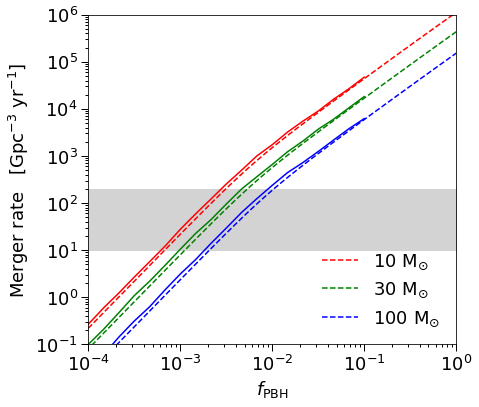

In [25]:
from scipy.interpolate import UnivariateSpline

print(rate_vec)
print(rate_remapped_vec)

mpl.rc('font', **{'size'   : 18})

#pl.figure(figsize=(6.1,6))
pl.figure(figsize=(7,6))

col = np.array(["red","green","blue"])

for iM in range(Nm):
    
    current_file = "rate_smooth_averaged_" 
    if (iM==0):
        lab="10 M$_{\odot}$"
        current_file += (str(m_vec[iM]) + ".txt")
    if (iM==1):
        lab="30 M$_{\odot}$"
        current_file += (str(m_vec[iM]) + ".txt")
    if (iM==2):
        lab="100 M$_{\odot}$"
        current_file += (str(m_vec[iM]) + ".txt")
        
    print("Reading ",current_file)        
    
    #f_vec, rate_remapped = np.loadtxt(current_file, delimiter=' ', usecols=(0, 2), unpack=True)    
    f_vec, rate_remapped_vec = np.loadtxt(current_file, usecols=(0, 2), unpack=True)  
        
    pl.loglog(f_vec_analytical, rate_vec_analytical[iM,:], linewidth=1.5, ls="--", label=lab, color=col[iM])
    pl.loglog(f_vec, rate_remapped_vec, linewidth=1.5, ls="-", color=col[iM])
    #pl.loglog(f_vec_hires, rate_remapped_smooth(f_vec_hires), linewidth=1.5, ls="-", color=col[iM])
    
pl.xlim(1.e-4,1.)
pl.ylim(.1,1.e6)
#pl.xlim(1.e-3,0.1)
#pl.ylim(1.,1.e3)

pl.fill_between(f_vec_analytical, 10., 200.0, color="lightGrey")
    
pl.xlabel(r"$f_{\rm PBH}$")
pl.ylabel(r"Merger rate   [Gpc$^{-3}$ yr$^{-1}$]")
pl.tight_layout()

pl.legend(loc='lower right', frameon=False)
pl.savefig("moneyPlot_smooth.pdf", format='pdf')

pl.show()

In [ ]:
def P_t_integ(a, t, whichPDF):
        
    c = 3.e5 #km/s
    Q = (c**6)*(3.0/170.0)*(G*M_PBH)**-3 # pc^-3
    t_pc = t*(60*60*24*365)*c*3.24078e-14 #Time in years -> Time in parsec    
    ecc = np.sqrt(1-(t_pc*1.0/(Q*a**4))**(2.0/7.0))
    j_ecc = np.sqrt(1. - ecc**2.)
    #print("eccentricity = ", ecc, "; j = ", j_ecc)
    #print a, ecc
    
    #######################################
    
    P1 = 1.
    if (whichPDF=="Sasaki"):
        P1 = Sasaki.P_ae(a, ecc, f, M_PBH)
    if (whichPDF=="Kamionkowski"):
        P1 = P_a_j(a, j_ecc)

    #######################################
    
    #print("P1 = ", P1)   
    djdt = j_ecc/(7*t)
    #print("dzde = ", dzde)
    #dzdj = 7 * H0_peryr * t / j_ecc 
    return P1*djdt

#Time in years
def P_t_remapped(z, whichPDF):
    
    #print("*** z = ", z)
    
    tF = t_univ(z)
        
    aFinalvals = np.logspace(np.log10(amin), np.log10(amax), 11) # CAREFUL HERE!
    test = np.asarray([P_t_integ(a_initial(aF), t_initial(tF,aF), whichPDF)*Jacobian(aF,tF) for aF in aFinalvals])
    
    #for ind in range(len(avals)):
    #    print(avals[ind], " ", test[ind])
        
    integr = np.trapz(test, avals)
 
    #return quad(P_t_integ, 0.0, 10.0,args=(t, f, M_PBH))[0]
    return integr


###########################################################################
    
#Calculate merger rate as a function of t (from Big Bang)    
def merger_rate_old(t_merge):
    return n_PBH*P_t(t_merge, WhichPDF) #Mergers per Gpc^3 per year

###########################################################################

#Calculate merger rate as a function of z
def merger_rate_z_old(z):
    return merger_rate(t_univ(z))

###########################################################################

#Calculate merger rate as a function of z
def merger_rate_z(z, whichPDF="Kamionkowski"):
    return P_z(z, whichPDF)

###########################################################################

wPDF = "Kamionkowski"
print("N_PBH [Gpc^-3] = ", n_PBH)
print("H0_peryr = ",H0_peryr)

#Integrate over sensitivity to get number of events
#We don't have the sensitivity curve for 30 Msun, so do 20 Msun and 40 Msun
integrand_20 = lambda x: n_PBH*sens_20Msun(x)*merger_rate_z(x, wPDF) # Gpc^(-3) * Gpc^3 yr * yr^(-1)
integrand_40 = lambda x: n_PBH*sens_40Msun(x)*merger_rate_z(x, wPDF)

#z_list = np.linspace(0., 0.7, num=10)
#merge_rate_list = np.asarray([merger_rate_z(x, wPDF) for x in z_list])
#for i in range(len(z_list)):
#    print(z_list[i], " ", merge_rate_list[i])

#Number of merger events above a given threshold in the search presented in 
N_20 = quad(integrand_20, 0, 0.7)[0]
N_40 = quad(integrand_40, 0, 0.7)[0]

print("Number of events above threshold:", N_20, "-", N_40)

N_20_flat = quad(sens_20Msun, 0, 0.7)[0]
N_40_flat = quad(sens_40Msun, 0, 0.7)[0]

print("Inferred Merger Rate [Gpc^-3 yr^-1]:", N_20/N_20_flat," - ",N_40/N_40_flat)